# WBGT in observations (ISIMIP3a): model eval with obsclim (20y period)

Obsclim 2000-2019, models at same warming level in 20 year period

Also have this preprocessed for 30 year period, could check -> might be more representative!

**Key results:**
- ERA5 gives much lower numbers / WBGT temperatures than W5E5
- Models much more similar to W5E5 than ERA5 (bias adjusted against this I think)
- This seems to be somewhat linked with GMT mapping earlier/later (over-correcting)

**To do**
- check with 30y instead of 20y
- add RMSE in diff maps
- see notes meeting with Wim, eval against nAHD not all WBGT measurements

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, (statsmodels?)

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4

%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import my variables settings functions from other scripts
from settings_ana import *

# import fxns 
from functions_ana import *
from utils_ana import *
from plotscript import *




In [2]:
start_message() # change indir to indir obs and datasets to datasets obs in start message

flags: {'models': 'ISIMIP3b', 'experiment': None, 'metric': 'WBGT28', 'method': None, 'time_method': None, 'shift_sigma': False, 'shift_period': None, 'shift_loglike': None, 'chunk_version': None, 'var': 'wbgt'}
var: wbgt
VARs: None
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0', 'EC-Earth3', 'UKESM1-0-LL', 'MPI-ESM1-2-HR', 'CNRM-ESM2-1']
datasets: ['GSWP3-W5E5', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_chunk: 120
tim

In [22]:
cellarea = xr.open_dataarray(os.path.join(datadirs,'geo-information/clm45_area.nc4'))
figdir = os.path.join(figdirs, 'fig_sep24')

In [2]:
from dask.distributed import Client 
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 40.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46777,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 1
Started: Just now,Total memory: 40.00 GiB
Comm: tcp://127.0.0.1:42793,Total threads: 1
Dashboard: http://127.0.0.1:41725/status,Memory: 40.00 GiB
Nanny: tcp://127.0.0.1:39669,


In [3]:
#figdir = os.path.join(figdirs, 'fig_apr24-isimip3a-wbgt')
figdir = os.path.join(figdirs, 'fig_sep24')


In [24]:
import numpy as np

def rmse_weighted(a, b, cellarea=cellarea, mask=True):
    """
    Calculates RMSE between a forecast, a, and an observation, b, 
    with area weighting using cellarea.
    """
    if mask:
        cellarea = cellarea * landmask
        a = a * landmask
        b = b * landmask 
    weighted_squared_errors = cellarea * (a - b) ** 2
    return np.sqrt(np.sum(weighted_squared_errors) / np.sum(cellarea))

def mae_weighted(a, b, cellarea=cellarea, mask=True):
    """
    Calculates mean absolute error between a and b, 
    with area weighting using cellarea.
    """
    if mask:
        cellarea = cellarea * landmask
        a = a * landmask
        b = b * landmask 
    weighted_absolute_errors = cellarea * np.abs(a - b)
    return np.sum(weighted_absolute_errors) / np.sum(cellarea)

def bias_weighted(a, b, cellarea=cellarea, mask=True):
    """
    Calculates mean bias between a and b, 
    with area weighting using cellarea.
    """
    if mask:
        cellarea = cellarea * landmask
        a = a * landmask
        b = b * landmask 
    weighted_errors = cellarea * (a - b)
    return np.sum(weighted_errors) / np.sum(cellarea)

# Open data obsclim and models 

In [4]:
datasets

['GSWP3-W5E5', '20CRv3-ERA5', '20CRv3-W5E5']

In [5]:
datasets_sel = datasets #datasets[0], datasets[2], datasets[3]

In [6]:
nyrs=20

da_p28_obs, da_p30_obs = [ open_all_wbgt_summary(GCMs=datasets_sel,
                            metric='WBGT',
                            open_what=open_what,
                            outdirname='output_wbgt',
                            experiment='obsclim',
                            period='present',
                            observations=True,
                            nyrs=nyrs).rename(name) for open_what, name in zip(['pctl28','pctl30'], ['gt28','gt30']) ]

da_mean_obs, da_min_obs, da_max_obs, da_std_obs = [ open_all_wbgt_summary(GCMs=datasets_sel,
                            metric='WBGT',
                            open_what=open_what,
                            outdirname='output_wbgt',
                            experiment='obsclim',
                            period='present',
                            observations=True,
                            nyrs=nyrs).rename(name) \
                                                   for  open_what, name in zip(
                                                                            ['timmean','timmin', 'timmax', 'timstd'], 
                                                                            ['wbgt_mean','wbgt_min', 'wbgt_max', 'wbgt_std']) ] 



In [9]:


da_p28_mod, da_p30_mod = [ open_all_wbgt_summary(GCMs=GCMs,
                            metric='WBGT',
                            open_what=open_what,
                            outdirname='output_wbgt',
                            experiment='historical-rcp370',
                            period='present',
                            observations=False,
                            nyrs=nyrs).rename(name) for open_what, name in zip(['pctl28','pctl30'], ['gt28','gt30']) ]

da_mean_mod, da_min_mod, da_max_mod, da_std_mod = [ open_all_wbgt_summary(GCMs=GCMs,
                            metric='WBGT',
                            open_what=open_what,
                            outdirname='output_wbgt',
                            experiment='historical-rcp370',
                            period='present',
                            observations=False,
                            nyrs=nyrs).rename(name) \
                                                   for  open_what, name in zip(
                                                                            ['timmean','timmin', 'timmax', 'timstd'], 
                                                                            ['wbgt_mean','wbgt_min', 'wbgt_max', 'wbgt_std']) ] 



# 1) Number of days crossing WBGT28 in present-day (2000-2019): models v. obs

Possibly calcuate summary stats only between -40 and 40 lat

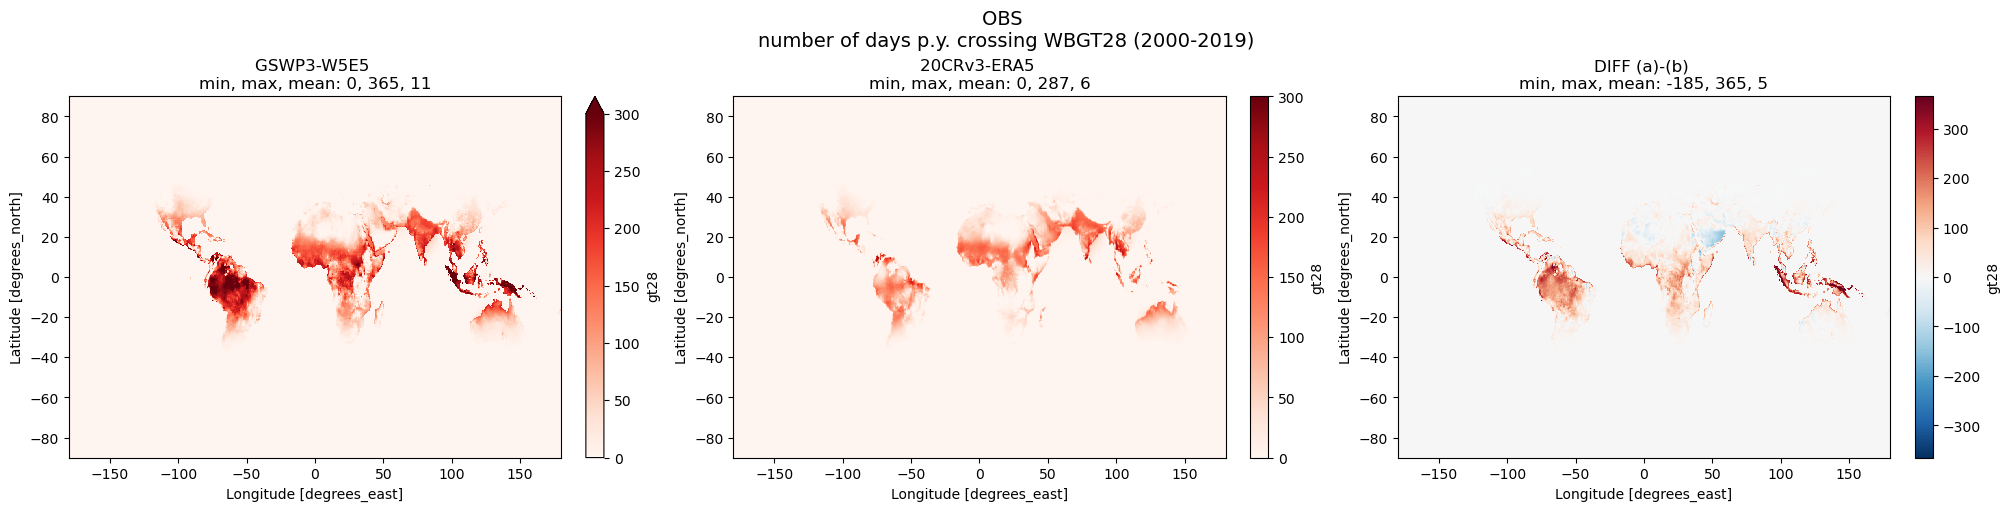

In [10]:
fig, axes = plt.subplots(1,3, figsize=(20,5),  layout='constrained')
axes = axes.flatten() 
vmax=300

for i,ax in enumerate(axes):
    if i < 2:
        data_plot= da_p28_obs.isel(model=i)  * 365
        data_plot.plot(ax=ax, vmax=vmax, cmap='Reds')
        ax.set_title(f'{data_plot.model.values} \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')
    if i == 2:
        data_plot= (da_p28_obs.isel(model=0) - da_p28_obs.isel(model=1))  * 365
        data_plot.plot(ax=ax)
        ax.set_title(f'DIFF (a)-(b) \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')

fig.suptitle('OBS \nnumber of days p.y. crossing WBGT28 (2000-2019)',size=14);

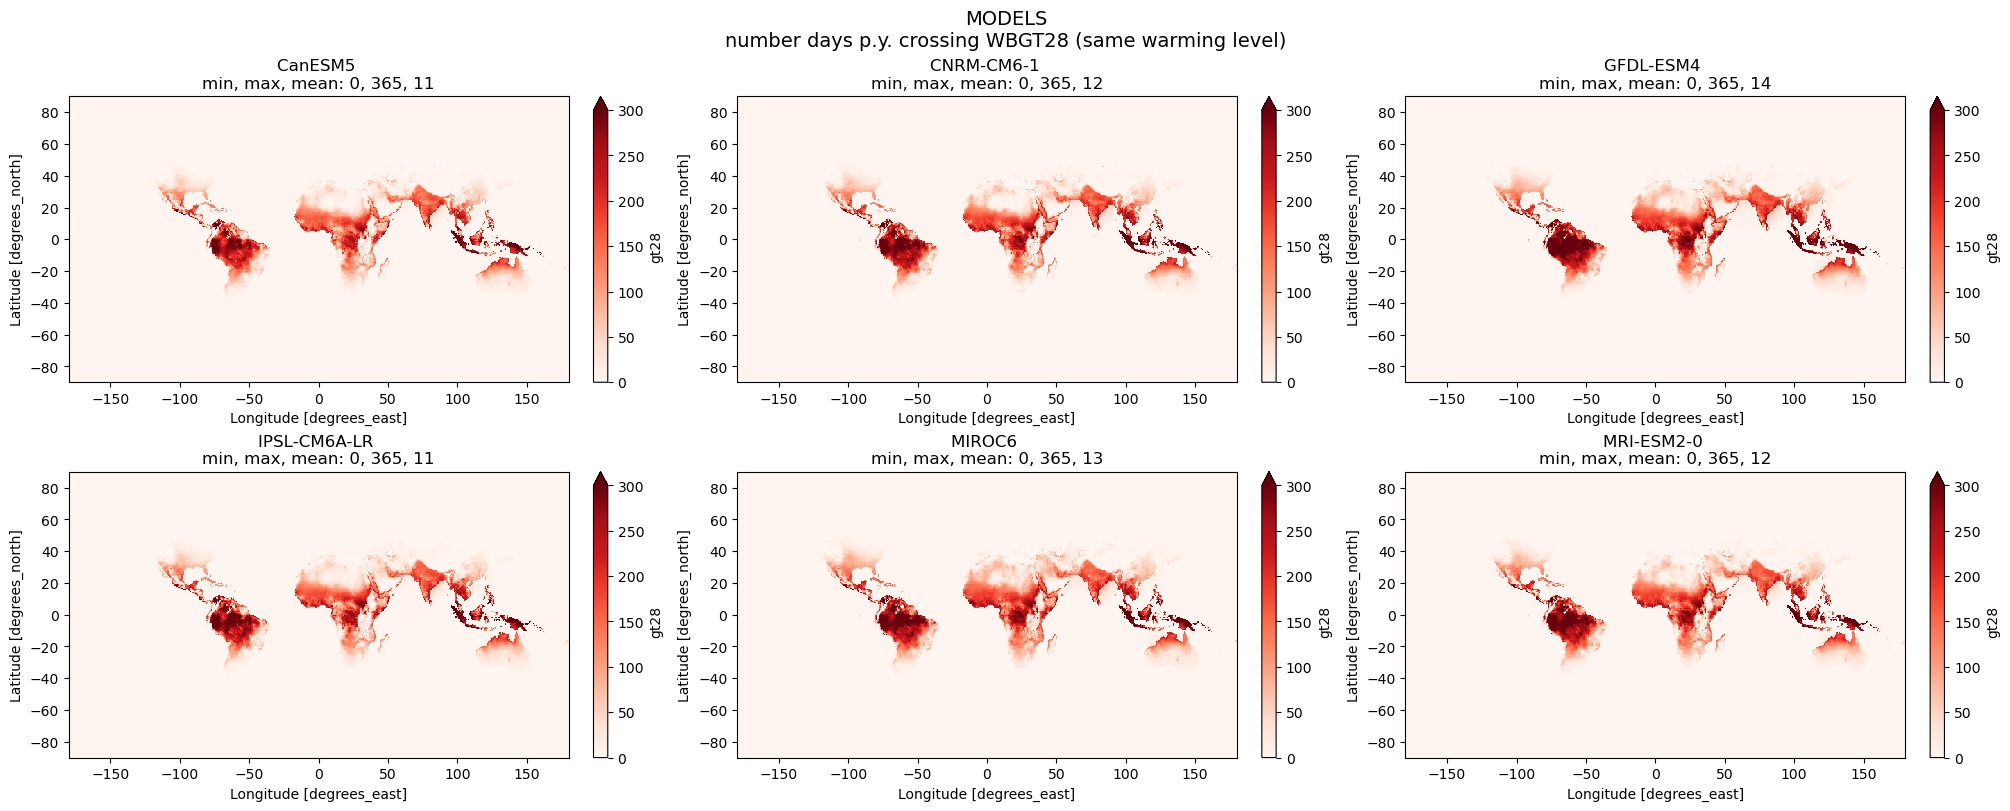

In [11]:
fig, axes = plt.subplots(2,3, figsize=(20,8),  layout='constrained')
axes = axes.flatten() 
vmax=300

for i,ax in zip(range(len(GCMs)), axes):
    data_plot= da_p28_mod.isel(model=i)  * 365
    data_plot.plot(ax=ax, vmax=vmax, cmap='Reds')
    ax.set_title(f'{data_plot.model.values.item()} \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')

fig.suptitle('MODELS\nnumber days p.y. crossing WBGT28 (same warming level)',size=14);

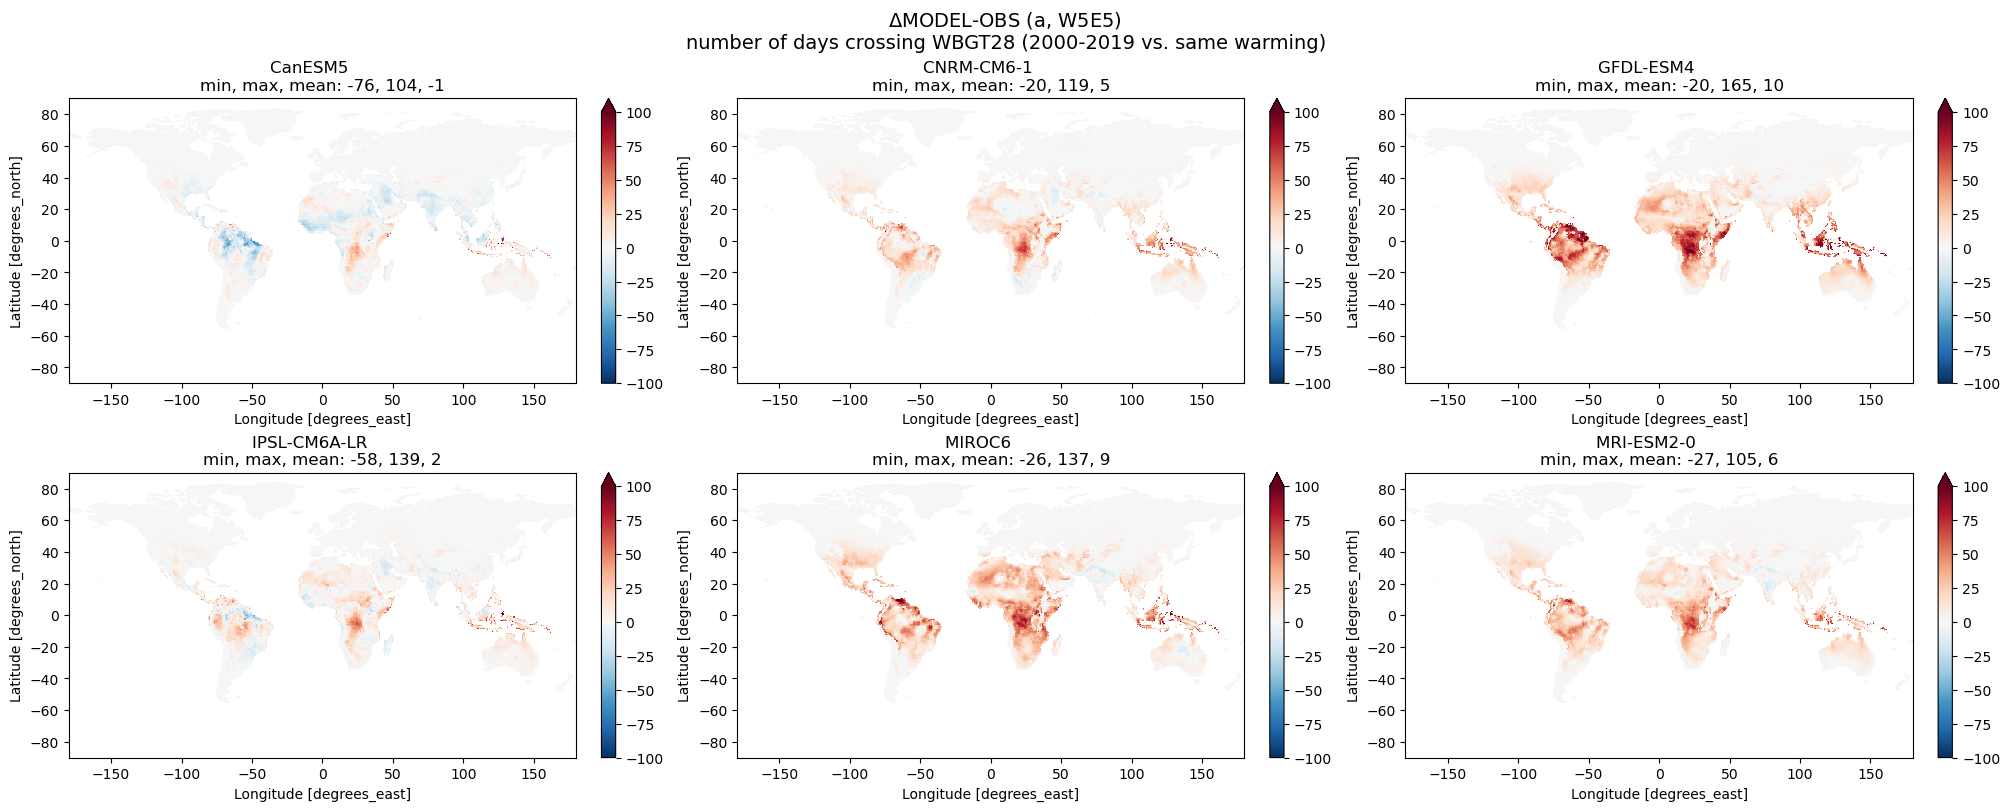

In [12]:
fig, axes = plt.subplots(2,3, figsize=(20,8),  layout='constrained')
axes = axes.flatten() 
vmax = 100
landmask = get_mask()

for i,ax in zip(range(len(GCMs)), axes):
    data_plot= (da_p28_mod.isel(model=i) - da_p28_obs.isel(model=0)) * 365 *landmask
    data_plot.plot(ax=ax, vmax=vmax)
    ax.set_title(f'{da_p28_mod.isel(model=i).model.values.item()} \
    \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')

fig.suptitle('$\Delta$MODEL-OBS (a, W5E5) \nnumber of days crossing WBGT28 (2000-2019 vs. same warming)', size=14);

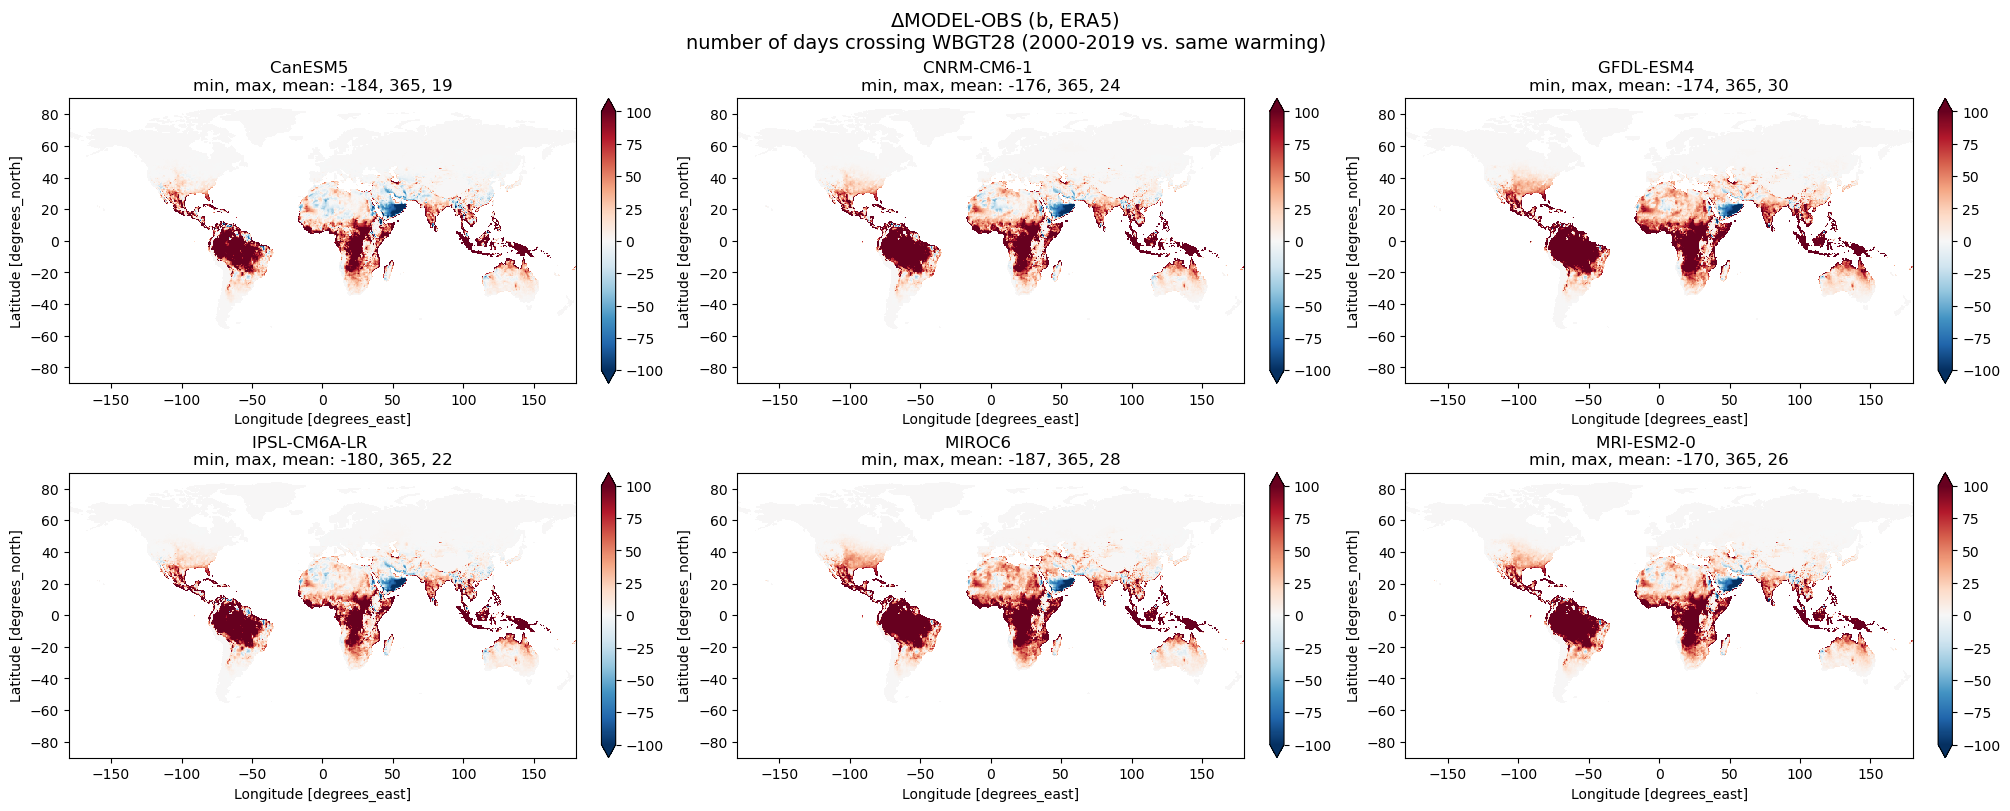

In [13]:
fig, axes = plt.subplots(2,3, figsize=(20,8),  layout='constrained')
axes = axes.flatten() 
vmax = 100
landmask = get_mask()

for i,ax in zip(range(len(GCMs)), axes):
    data_plot= (da_p28_mod.isel(model=i) - da_p28_obs.isel(model=1)) * 365 *landmask
    data_plot.plot(ax=ax, vmax=vmax)
    ax.set_title(f'{da_p28_mod.isel(model=i).model.values.item()} \
    \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')

fig.suptitle('$\Delta$MODEL-OBS (b, ERA5) \nnumber of days crossing WBGT28 (2000-2019 vs. same warming)', size=14);

## Times when models were mapped to 

Models mapped further back in past (hot models, CanESM5,IPSL) are possibly over-corrected, and give a bit cold results (CanESM gives cold, IPSL doesn't have a huge systematic bias). 

Models mapped into the future (cold models, GFDL, MIROC) are generally hot in terms of WBGT. 

MRI and CNRM are near the right year and are a bit hot. 

To do:
- compare also mean WBGT and other metrics, not only n of exceedances of 28 

In [15]:
df_gmtmap=pd.read_csv(os.path.join('../../output/output_gmt-mapping/df_gmt_mapping_endyear2019_eval.csv'))
df_gmtmap

,model,10_yr,20_yr,30_yr
0,obs,2019,2019,2019
1,CanESM5,2004,2008,2009
2,CNRM-CM6-1,2021,2021,2020
3,GFDL-ESM4,2029,2029,2029
4,IPSL-CM6A-LR,2009,2010,2011
5,MIROC6,2034,2034,2033
6,MRI-ESM2-0,2021,2022,2024


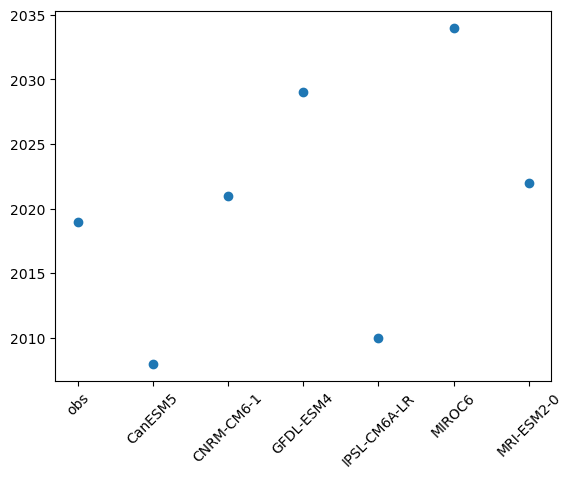

In [16]:
df_gmtmap['20_yr'].plot(linestyle="",marker="o")
plt.xticks(range(7),df_gmtmap.model, rotation=45);

## hist and scatterplot MODELS v. OBS restricted 40 N / 40 S and W5E5

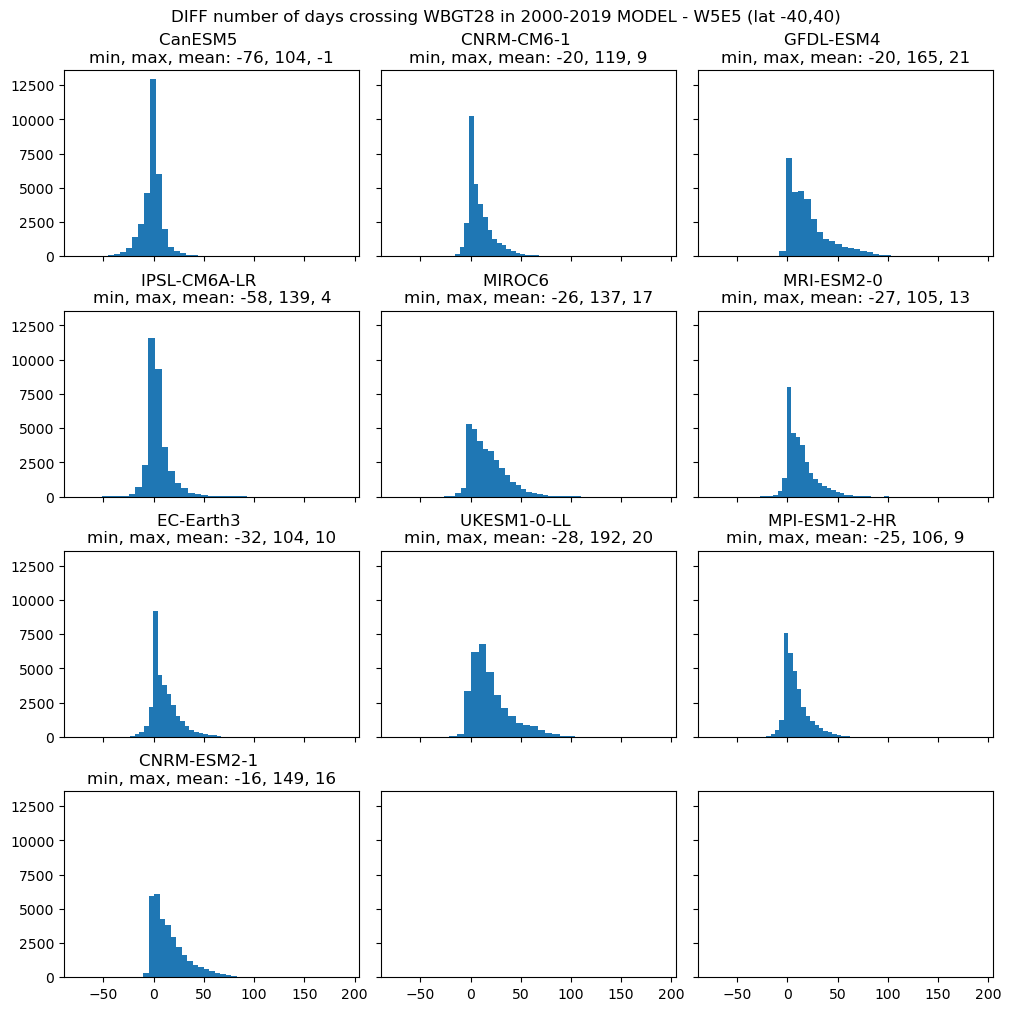

In [33]:
fig, axes = plt.subplots(4,3, figsize=(10,10),  layout='constrained', sharex=True, sharey=True)
axes = axes.flatten() 
vmax = 100
landmask = get_mask()

for i,ax in zip(range(len(GCMs)), axes):
    data_plot= (da_p28_mod.isel(model=i).sel(lat=slice(40,-40)) - da_p28_obs.isel(model=0)).sel(lat=slice(40,-40)) * 365 * landmask
    data_plot.plot.hist(ax=ax, bins=30)
    ax.set_title(f'{da_p28_mod.isel(model=i).model.values.item()} \
    \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')

fig.suptitle('DIFF number of days crossing WBGT28 in 2000-2019 MODEL - W5E5 (lat -40,40)');

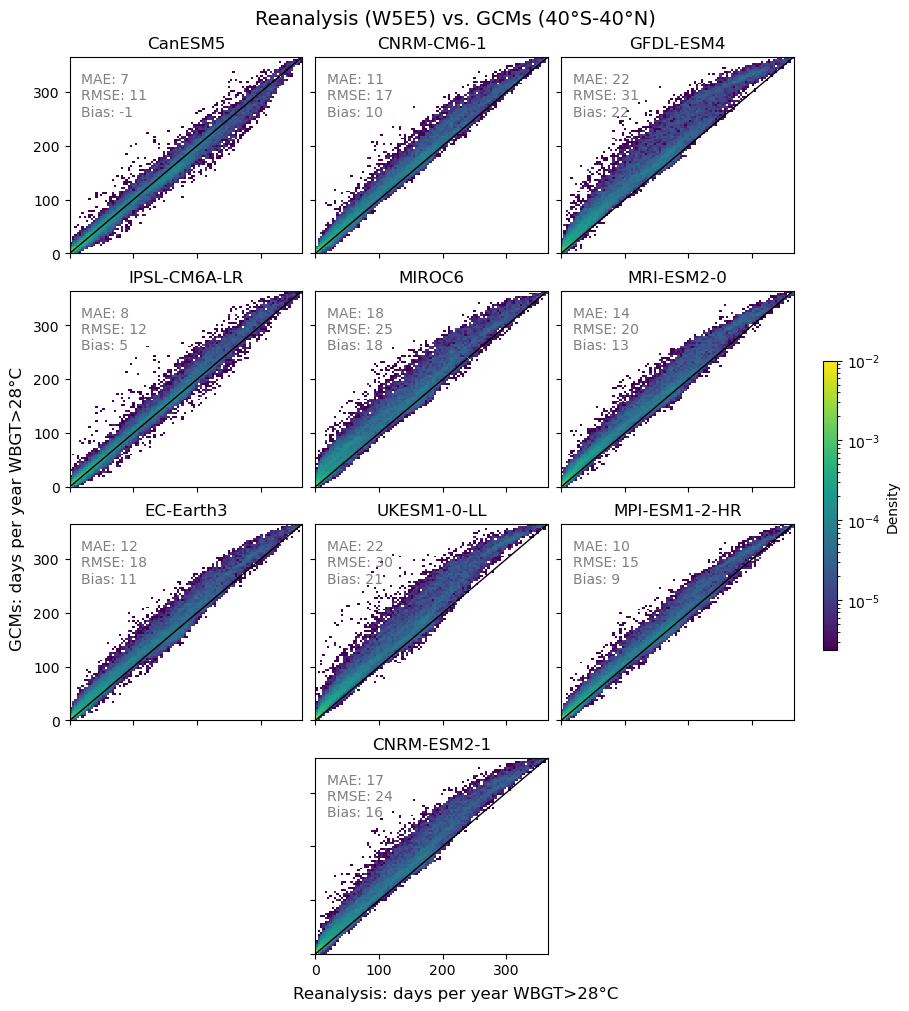

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

fig, axes = plt.subplots(4, 3, figsize=(9, 10), constrained_layout=True, sharex=True, sharey=True)
axes = axes.flatten()
vmax = .01

# Collect all histograms for shared colorbar scaling
hist_data = []

cellarea_sel = cellarea.sel(lat=slice(40, -40))

# Plot data on the first 10 axes, ignore the last two
for i, ax in enumerate( np.concatenate((axes[:len(GCMs)-1], [axes[-2]])) ):
    if i >= 10:
        break
    data1 =da_p28_obs.isel(model=0).sel(lat=slice(40,-40)) * 365 * landmask
    data2 = da_p28_mod.isel(model=i).sel(lat=slice(40,-40))  * 365 * landmask
    
    x = data1.values.flatten()
    y = data2.values.flatten()
    xy = np.column_stack([x, y])
    xy = xy[~np.isnan(xy).any(axis=1)]
    
    h = ax.hist2d(xy[:, 0], xy[:, 1], bins=100, density=True, norm=colors.LogNorm(vmax=vmax) )
    hist_data.append(h[3])  # Store the mappable object for colorbar scaling

    ax.axline((0, 0), slope=1, color='k', linewidth=1)
    ax.set_title(f'{data2.model.values.item()}')
    ax.set_ylim([0,365])
    ax.set_xlim([0,365])
    ax.text(.05,.7, 
            f"MAE: {int(mae_weighted(data2, data1, cellarea_sel ).values.round(0))}\n"
            f"RMSE: {int(rmse_weighted(data2, data1, cellarea_sel).values.round(0))}\n"
            f"Bias: {int(bias_weighted(data2, data1, cellarea_sel).values.round(0))}" ,
            transform=ax.transAxes,
            c='gray')

# Add a single colorbar shared across all subplots
cbar = fig.colorbar(hist_data[0], ax=axes[:len(GCMs)], orientation="vertical", fraction=0.02, pad=0.04)
cbar.set_label('Density')

# Remove the two empty subplots
for ax in (axes[-3], axes[-1]):
    ax.remove()

fig.suptitle('Reanalysis (W5E5) vs. GCMs (40°S-40°N)',fontsize=14)
fig.supxlabel('Reanalysis: days per year WBGT>28°C')
fig.supylabel('GCMs: days per year WBGT>28°C ');


#plt.savefig(os.path.join(figdir,'figSI_modeleval_rp_wbgt28_20years.pdf'),dpi=300,transparent=True)
#plt.savefig(os.path.join(figdir,'figSI_modeleval_rp_wbgt28_20years.png'),dpi=300,transparent=True)



# 2) Mean WBGT

Biases generally within +/- 2 degrees 

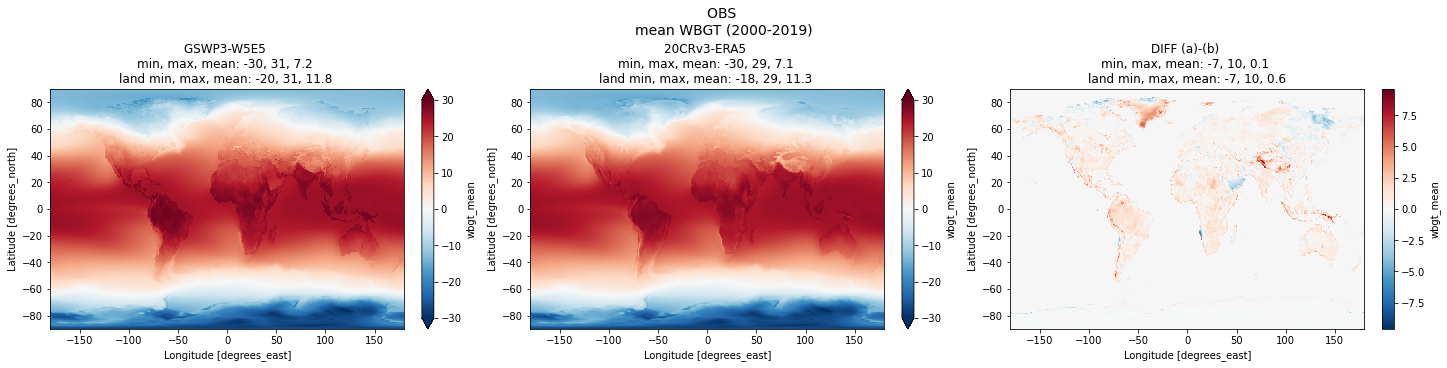

In [206]:
fig, axes = plt.subplots(1,3, figsize=(20,5),  layout='constrained')
axes = axes.flatten() 
vmax=30

for i,ax in enumerate(axes):
    if i < 2:
        data_plot= da_mean_obs.isel(model=i)
        data_plot.plot(ax=ax,vmax=vmax,extend='both')
        ax.set_title(f'{data_plot.model.values} \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.1f} \nland min, max, mean: {(data_plot*landmask).min().item():.0f}, {(data_plot*landmask).max().item():.0f}, {(data_plot*landmask).mean().item():.1f} ')
    if i == 2:
        data_plot= (da_mean_obs.isel(model=0) - da_mean_obs.isel(model=1)) 
        data_plot.plot(ax=ax)
        ax.set_title(f'DIFF (a)-(b) \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.1f} \nland min, max, mean: {(data_plot*landmask).min().item():.0f}, {(data_plot*landmask).max().item():.0f}, {(data_plot*landmask).mean().item():.1f}')

fig.suptitle('OBS \nmean WBGT (2000-2019)',size=14);

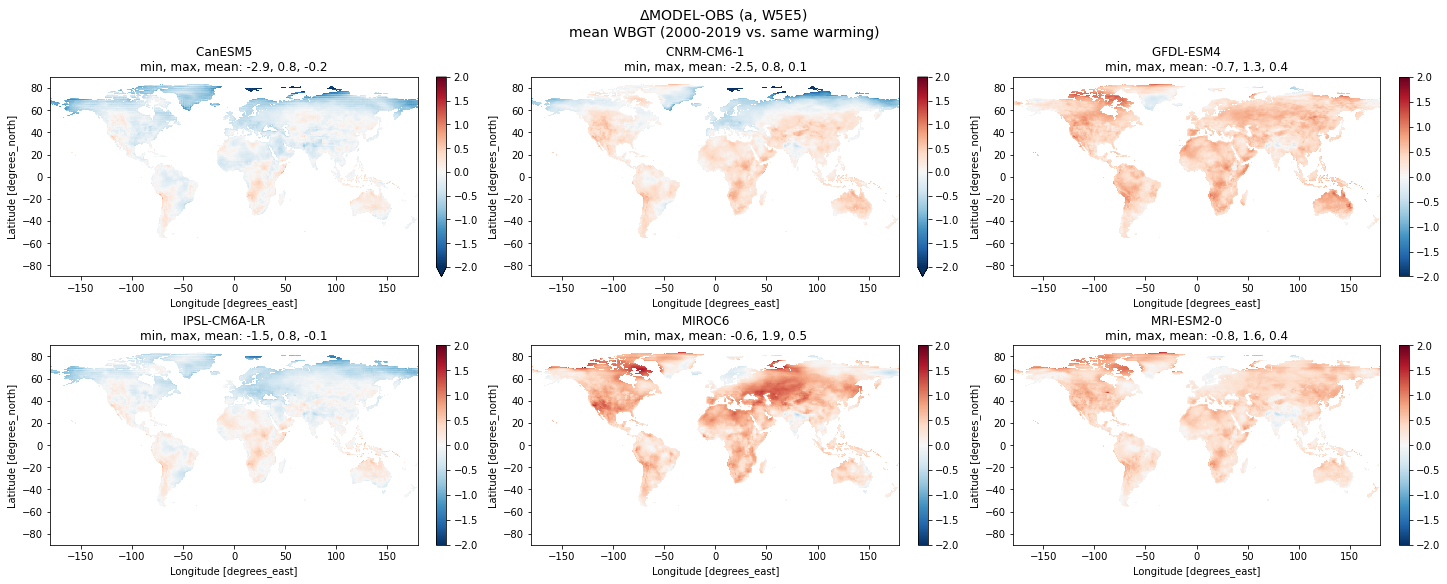

In [217]:
fig, axes = plt.subplots(2,3, figsize=(20,8),  layout='constrained')
axes = axes.flatten() 
vmax=2
landmask = get_mask()

for i,ax in zip(range(len(GCMs)), axes):
    data_plot= (da_mean_mod.isel(model=i) - da_mean_obs.isel(model=0)) *landmask
    data_plot.plot(ax=ax,vmax=vmax)
    ax.set_title(f'{da_p28_mod.isel(model=i).model.values.item()} \
    \nmin, max, mean: {data_plot.min().item():.1f}, {data_plot.max().item():.1f}, {data_plot.mean().item():.1f}')

fig.suptitle('$\Delta$MODEL-OBS (a, W5E5) \nmean WBGT (2000-2019 vs. same warming)', size=14);

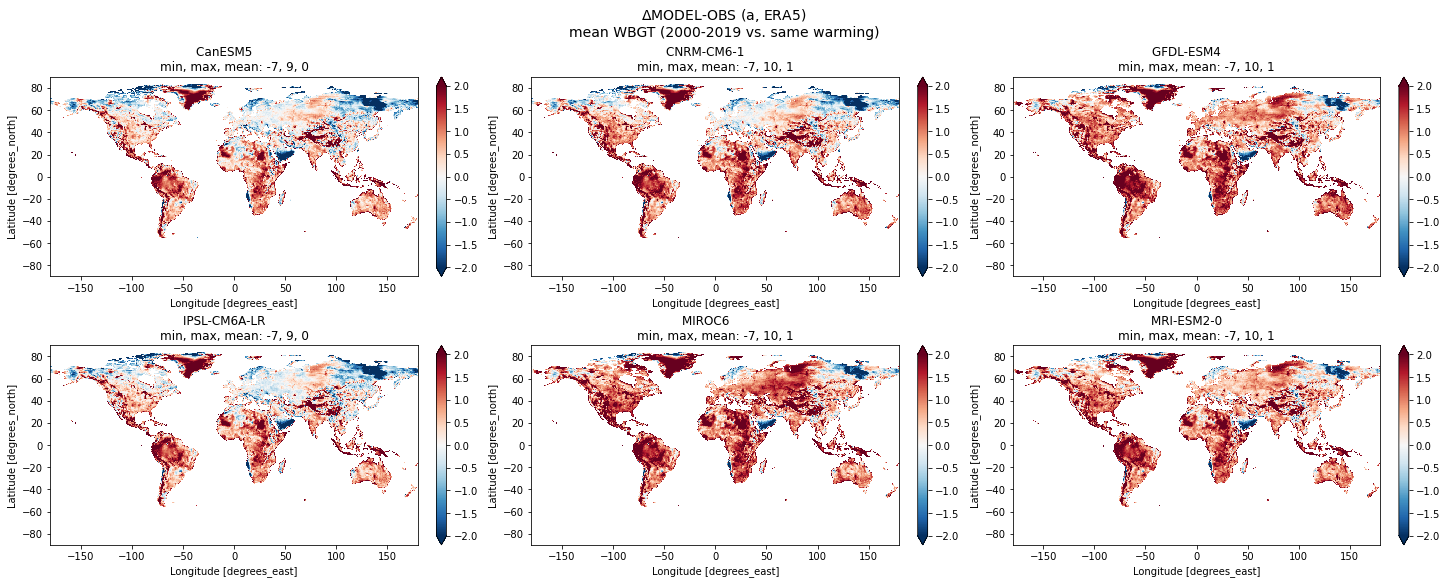

In [216]:
fig, axes = plt.subplots(2,3, figsize=(20,8),  layout='constrained')
axes = axes.flatten() 
vmax=2
landmask = get_mask()

for i,ax in zip(range(len(GCMs)), axes):
    data_plot= (da_mean_mod.isel(model=i) - da_mean_obs.isel(model=1)) *landmask
    data_plot.plot(ax=ax,vmax=vmax)
    ax.set_title(f'{da_p28_mod.isel(model=i).model.values.item()} \
    \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')

fig.suptitle('$\Delta$MODEL-OBS (a, ERA5) \nmean WBGT (2000-2019 vs. same warming)', size=14);

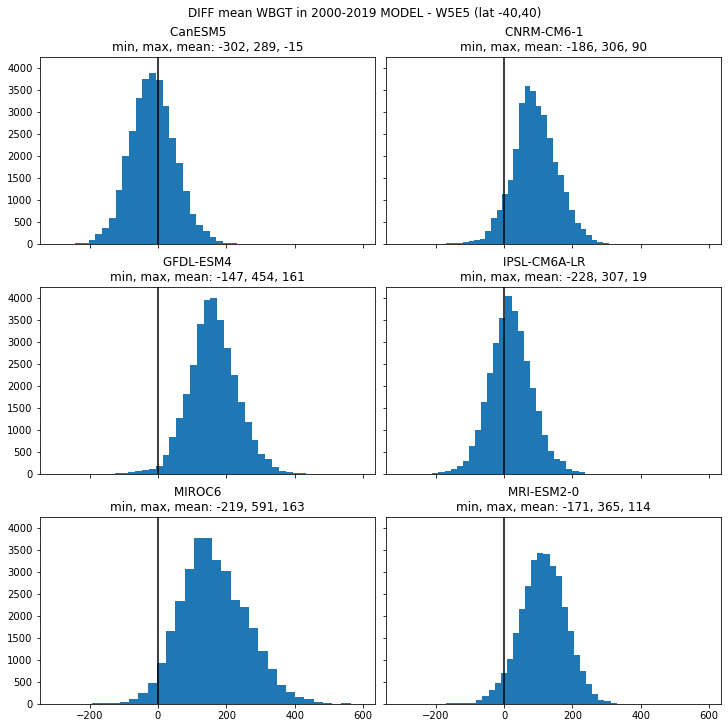

In [222]:
fig, axes = plt.subplots(3,2, figsize=(10,10),  layout='constrained', sharex=True, sharey=True)
axes = axes.flatten() 
landmask = get_mask()

for i,ax in zip(range(len(GCMs)), axes):
    data_plot= (da_mean_mod.isel(model=i).sel(lat=slice(40,-40)) - da_mean_obs.isel(model=0)).sel(lat=slice(40,-40)) * 365 * landmask
    data_plot.plot.hist(ax=ax, bins=30)
    ax.axvline(0,c='k')
    ax.set_title(f'{da_p28_mod.isel(model=i).model.values.item()} \
    \nmin, max, mean: {data_plot.min().item():.0f}, {data_plot.max().item():.0f}, {data_plot.mean().item():.0f}')

fig.suptitle('DIFF mean WBGT in 2000-2019 MODEL - W5E5 (lat -40,40)');